# Depth estimation of mono-camera images for Visual SLAM 

In [1]:
# !unzip example_dataset.zip

In [2]:
!nvidia-smi

Sun Apr 25 21:01:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0  On |                  N/A |
| 32%   54C    P8    17W / 250W |    931MiB / 11175MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3080    Off  | 00000000:0A:00.0 Off |                  N/A |
| 59%   

In [3]:
import tensorflow as tf

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Dense, BatchNormalization, Dropout, MaxPool2D, Input, SeparableConv2D, Lambda, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import backend as K

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Let's try to create an Autoencoder network (UNET)

Unet has three parts:
- Downsampling   (skip connection to upsampling)
- Bottleneck
- Upsampling

In [6]:
# Use billinear additive upsampling (BAU) and separable convolution to reduce the total amount of hyperparameters
def BAU_layer(last_layer, channel_num):
    additive = []
    depth = int(last_layer.get_shape()[-1])
    step = int(depth / channel_num)
    last_layer[:, :, :, 1*step:(1*step+step)]
    for i in range(channel_num):
        layersum = K.mean(last_layer[:, :, :, i*step:(i*step+step)], axis = -1)
        additive.append(layersum)
    additive = K.stack(additive, axis = -1)
    return additive

def upsampling_step(skipped_conv, num_output_filters, prev_conv = None):
    num_filters = skipped_conv.output_shape[-1]
    up_sampling_1 = UpSampling2D((2,2))(prev_conv)
    if prev_conv != None:
        concat_layer = tf.keras.layers.concatenate([up_sampling_1, skipped_conv.output])
    else:
        concat_layer = skipped_conv.output
    conv1 = SeparableConv2D(num_filters, 3, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(concat_layer)
    conv2 = SeparableConv2D(num_filters, 3, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(conv1)
#     up = UpSampling2D()(conv2)
    BAU = Lambda(BAU_layer, arguments = {'channel_num': num_output_filters})(conv2)
    conv3 = SeparableConv2D(num_output_filters, 2, padding = 'same', activation = 'relu',
                           depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal')(BAU)
    return conv3

def output(feature_map, mask = True):
    if mask:
        conv3 = Conv2D(7, 1, padding = 'same', activation = 'sigmoid', kernel_initializer = 'he_normal', name = 'masks')(feature_map)
    else:
        conv3 = Conv2D(1, 1, padding = 'same', activation = 'sigmoid', kernel_initializer = 'he_normal', name = 'edges')(feature_map)
    return conv3



In [7]:
def down_block(x, filters, kernel_s = (3,3), 
              padding_ = 'same', strides_ = 1, 
              activation_ = 'relu'):

    conv1_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(x)
    x = BatchNormalization()(conv1_layer)
    conv2_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(x)

    pooling_layer = MaxPool2D((2,2), strides=(2,2))(conv2_layer)

    return conv2_layer, pooling_layer

def bottleneck(x, filters, kernel_s = (3,3), 
               padding_ = 'same', strides_ = 1, 
               activation_ = 'relu'):

    conv1_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(x)

    conv2_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(conv1_layer)
    return conv2_layer
  

def up_block(x, skip, filters, kernel_s = (3,3), 
                     padding_ = 'same', strides_ = 1, 
                     activation_ = 'relu'):

    up_sampling_1 = UpSampling2D((2,2))(x)
    concat1 = Concatenate()([up_sampling_1, skip])

    conv1_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(concat1)

    conv2_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(conv1_layer)
    return conv2_layer

def next_up_block(x, skip, filters, kernel_s = (3,3), 
                     padding_ = 'same', strides_ = 1, 
                     activation_ = 'relu'):

    x = UpSampling2D((2,2))(x)
    if skip is not None:
        x = Concatenate()([x, skip])

    conv1_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, kernel_initializer='he_uniform',
                        activation=activation_)(x)

    conv2_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, kernel_initializer='he_uniform',
                        activation=activation_)(conv1_layer)
    return conv2_layer

def resnet50_model(input_shape):
    inputs = Input(input_shape)

    '''Load pre-trained resnet50 '''
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs) # no classifier layers needed.
    for layer in resnet50.layers:
        layer.trainable = False
    resnet50.summary()
    keras.utils.plot_model(resnet50, show_shapes=True)
    
    skiplayers = [174, 142, 80, 38, 4]
    skip_enc = []
    for i in skiplayers:
        skip_enc.append(resnet50.layers[i])
    print(skip_enc)
    
    ''' Encoder '''
    s1 = resnet50.layers[0].output                      #128 ("input_1")
    s2 = resnet50.layers[4].output        #64, 64  filters  ("conv1_relu")
    s3 = resnet50.layers[38].output  #32, 256 filters  ("conv2_block3_out")
    s4 = resnet50.layers[80].output  #16, 512 filters  ("conv3_block4_out")
#     s4 = resnet50.layers[142].output  #8, 1024 filters  ("conv4_block6_out")
#     s5 = resnet50.layers[174].output  # 4, 1048
    
    ''' Bottleneck '''
    pooling_layer = MaxPool2D((2,2), strides=(2,2))(s4)
    bn = bottleneck(pooling_layer, filters = 1024)

    ''' Decoder '''
    d1 = next_up_block(bn, s4, 1024)
    d2 = next_up_block(d1, s3, 512)
    d3 = next_up_block(d2, s2, 256)
    d4 = next_up_block(d3, s1, 64)
#     d5 = next_up_block(d4, None, 16)

    outputs = Conv2D(1, kernel_size=(1,1), padding='same', activation='sigmoid')(d4)
    outputs = Activation(activation='relu')(outputs)
    model = keras.models.Model(inputs, outputs)

    return model

model = resnet50_model((128, 128, 3))
model.summary()


model.compile(optimizer='adam', loss='mse')
# model.summary()
# keras.utils.plot_model(model, show_shapes=True)
'''
    Layer Number - size - filters
    Layer 3      - 64   - 64
    
'''

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

'\n    Layer Number - size - filters\n    Layer 3      - 64   - 64\n    \n'

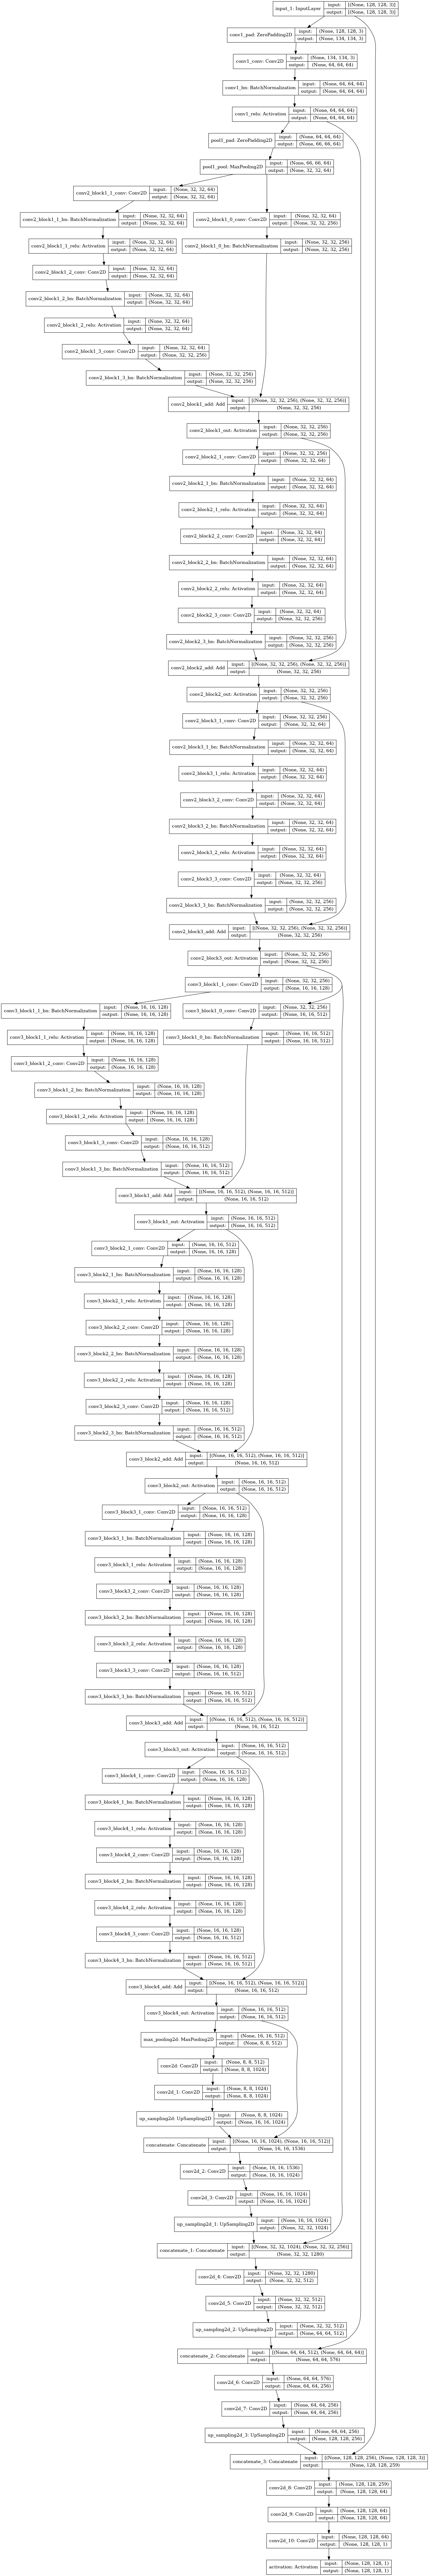

In [8]:
keras.utils.plot_model(model, show_shapes=True)

In [9]:
model.compile(optimizer='adam', loss='mse')
# model.summary()
# keras.utils.plot_model(model, show_shapes=True)

In [10]:
# finish this later on...
import tensorflow.keras as keras
class DataGenerator(keras.utils.Sequence):
  
  def __init__(self, batch_size = 8, image_size = 128):
    self.batch_size = batch_size
    self.image_size = image_size
    
  def load(self, rgb_file, depth_file):
    image = cv2.imread(rgb_file)
    image = cv2.resize(image, (self.image_size, self.image_size)) # resize...
    depth = cv2.imread(depth_file, -1)
    depth = cv2.resize(depth, (self.image_size, self.image_size)) 

    image_normalized = image/np.max(image)
    depth_normalized = depth/np.max(depth) # double check the depth images!
    return image_normalized, depth_normalized

  def load_all(self, rgb_files, depth_files):
        images = []
        depths = []
        for i in range(len(rgb_files)):
            img, dpth = self.load(rgb_files[i], depth_files[i])
            images.append(img)
            depths.append(dpth)
        return np.array(images), np.array(depths)

In [11]:
# Get file names
rgb_images = os.listdir('rgb/')
rgb_images.sort()
rgb_images = [str('rgb/') + file for file in rgb_images]
depth_images = os.listdir('depth/')
depth_images.sort()
depth_images = [str('depth/') + file for file in depth_images]

test_size = 20
rgb_images_test = rgb_images[:test_size]
depth_images_test = depth_images[:test_size]

rgb_images_train = rgb_images[test_size:]
depth_images_train = depth_images[test_size:]

# Load data:

load_data = DataGenerator()

X_train, y_train = load_data.load_all(rgb_files=rgb_images_train, 
                                      depth_files=depth_images_train)

X_test, y_test = load_data.load_all(rgb_files=rgb_images_test, 
                                  depth_files=depth_images_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(81, 128, 128, 3) (81, 128, 128)
(20, 128, 128, 3) (20, 128, 128)


In [12]:
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(y_train)))

False
False


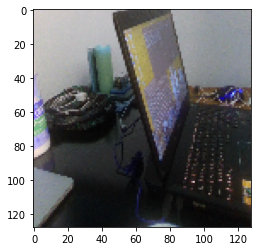

In [13]:
plt.imshow(X_train[80])

In [14]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

In [15]:
# Create Model Checkpoint for tensorboard and saving checkpoints
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoint/',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True
)

In [16]:
# model.fit(X_train, y_train, batch_size=2, epochs=1000, validation_split=0.2, verbose=1, callbacks=[model_checkpoint_callback])
model.fit(X_train, y_train, batch_size=2, epochs=50, validation_split=0.2, verbose=1)

Epoch 1/50
32/32 [==============================] - 114s 1s/step - loss: 0.5595 - val_loss: 0.4506
Epoch 2/50
32/32 [==============================] - 1s 36ms/step - loss: 0.6440 - val_loss: 0.4506
Epoch 3/50
32/32 [==============================] - 1s 36ms/step - loss: 0.6308 - val_loss: 0.4506
Epoch 4/50
32/32 [==============================] - 1s 35ms/step - loss: 0.6405 - val_loss: 0.4506
Epoch 5/50
32/32 [==============================] - 1s 35ms/step - loss: 0.6233 - val_loss: 0.4506
Epoch 6/50
32/32 [==============================] - 1s 36ms/step - loss: 0.6282 - val_loss: 0.4506
Epoch 7/50
32/32 [==============================] - 1s 35ms/step - loss: 0.6257 - val_loss: 0.4506
Epoch 8/50
32/32 [==============================] - 1s 35ms/step - loss: 0.6390 - val_loss: 0.4506
Epoch 9/50
32/32 [==============================] - 1s 35ms/step - loss: 0.6103 - val_loss: 0.4506
Epoch 10/50
32/32 [==============================] - 1s 35ms/step - loss: 0.6441 - val_loss: 0.4506
Epoch 11/

In [17]:
preds = model.predict(X_test)

PREVIOUS UNET SIMPLE MODEL

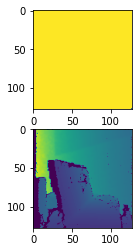

In [18]:
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(2,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(2,1,2)
plt.imshow(y_test[0]*255)

RESNET ENCODER MODEL RESULTS - not enough training!